In [185]:
library(tidyverse)
library(dplyr)
library(tidyr)
library(recipes)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [269]:
players_csv <- read_csv('players.csv')
#players_csv

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


→ A | warning: prediction from rank-deficient fit; consider predict(., rankdeficient="NA")

There were issues with some computations   A: x1

There were issues with some computations   A: x10



→ A | warning: prediction from rank-deficient fit; consider predict(., rankdeficient="NA")

There were issues with some computations   A: x5

There were issues with some computations   A: x10



→ A | warning: prediction from rank-deficient fit; consider predict(., rankdeficient="NA")

→ A | warning: prediction from rank-deficient fit; consider predict(., rankdeficient="NA")

There were issues with some computations   A: x10

There were issues with some computations   A: x10



→ A | warning: prediction from rank-deficient fit; consider predict(., rankdeficient="NA")

→ A | warning: prediction from rank-deficient fit; consider predict(., rankdeficient="NA")

→ A | warning: prediction from rank-deficient fit; consider predict(., rankdeficient="NA")

There were issues with some computations   A: 

size,model_string,rmse
<int>,<chr>,<dbl>
1,played_hours ~ Age,19.02063
2,played_hours ~ Age+subscribe,19.23687
3,played_hours ~ Age+subscribe+experience,20.72916
4,played_hours ~ Age+subscribe+experience+gender,23.12056


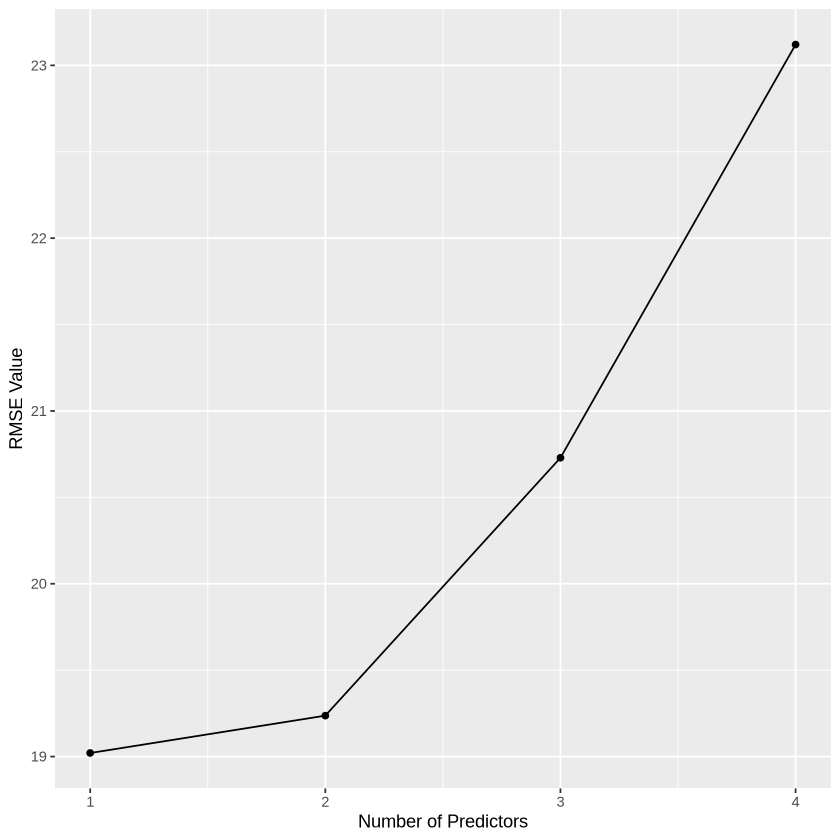

In [285]:
#----------------------------------- Forward Selection -----------------------------------#

# SPLITTING DATA SETS INTO TESTING AND TRAINING SETS:
players_split <- players_csv |>
    initial_split(prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

# FINDING BEST PREDICTOR COMBINATION VIA FOWARD SELECTION:

# create tbl containing all the predictors
possible_predictors <- colnames(players_training |> select(Age, gender, experience, subscribe))

# Finding most meaningful predictors

# create an empty tibble to store the results
accuracies <- tibble(size = integer(),
                     model_string = character(),
                     rmse = numeric())

# create a model specification
players_spec <- linear_reg() |>
    set_engine('lm') |>
    set_mode("regression")

# create a 10-fold cross-validation object
players_vfold <- vfold_cv(players_training, v = 10)

# store the total number of predictors
n_total <- length(possible_predictors)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    
# for every predictor still not added yet
accs <- list()
models <- list()
for (j in 1:length(possible_predictors)) {
        
# create a model string for this combination of predictors
preds_new <- c(selected, possible_predictors[[j]])
model_string <- paste('played_hours', "~", paste(preds_new, collapse="+"))

# create a recipe from the model string
players_recipe <- recipe(as.formula(model_string), data = players_training) |>
    #step_unknown(all_nominal_predictors()) |>
    step_novel(all_nominal_predictors()) |>
    step_dummy(all_nominal(), one_hot = FALSE)
    
# tune model
acc <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit_resamples(resamples = players_vfold, metrics = metric_set(rmse)) |>
    collect_metrics() |>
    filter(.metric == 'rmse') |>
    summarize(mx = min(mean))
    acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.min(unlist(accs))
    accuracies <- accuracies |>
      add_row(size = i,
              model_string = models[[jstar]],
              rmse = accs[[jstar]])
    selected <- c(selected, possible_predictors[[jstar]])
    possible_predictors <- possible_predictors[-jstar]
}
accuracies

predictors_plot <- accuracies |>
    ggplot(aes(x = size,
               y = rmse)) +
    geom_point() +
    geom_line() +
    labs(x = 'Number of Predictors',
         y = 'RMSE Value')

predictors_plot

In [ ]:
#-------------------------------------- Final Model --------------------------------------#

# Using subscribe and Age as predictors as they are found to be most influential:
# Create final recipe:
players_recipe_final <- recipe(played_hours ~ Age + subscribe) |>
    